# 🌊 **Clipping North Atlantic Ocean by Latitude Bands**

This notebook prepares the **North Atlantic Ocean** geometry for **zonal analysis** by clipping it into latitude-based regions. We use global latitude bands to divide the ocean into horizontal slices (e.g., 30°N–40°N), then calculate daily chlorophyll-a concentration trends within each slice.

The workflow includes:
- Loading the **GOaS ocean boundaries** and **latitude band** datasets.
- Clipping the **North Atlantic** region by each latitude band.
- Extracting **daily chlorophyll values** per band from a NetCDF raster.
- Exporting a time series of chlorophyll means and generating plots.

## 📑 Table of Contents
- [🧰 1. Import Required Libraries](#1-import-required-libraries)  
- [🌊 2. Load Ocean Vector (GOaS)](#2-load-ocean-vector-goas)  
- [🗺️ 3. Load Latitude Bands](#3-load-latitude-bands)  
- [✂️ 4. Clip Ocean by Latitude](#4-clip-ocean-by-latitude)  
- [📈 5. Extract Chlorophyll Data](#5-extract-chlorophyll-data)  
- [📊 6. Visualize Time Series](#6-visualize-time-series)
- [🧭 7. Next Steps](#7-next-steps)


## 🧰 **1. Import Required Libraries**

- **Geospatial libraries**  
  For working with map data like polygons and raster files:  
  - `geopandas` loads and manipulates vector data (e.g., shapefiles, GeoJSON).  
  - `shapely` helps define and clean up geometric shapes.  
  - `rasterio` and `rioxarray` let us read and clip NetCDF raster files (like chlorophyll data).  

- **Data handling and computation**  
  For loading, cleaning, and processing data efficiently:  
  - `pandas` handles tabular data.  
  - `numpy`, `xarray`, and `dask` allow large, multi-dimensional data processing in chunks.  

- **Plotting libraries**  
  To visualize chlorophyll concentrations and trends:  
  - `matplotlib.pyplot` draws plots and maps.  
  - `matplotlib.dates` formats date-based x-axes.  
  - `matplotlib.cm` provides access to color palettes.  

- **Utilities**  
  For smooth workflows and progress tracking:  
  - `tqdm` shows progress bars in loops.  
  - `pathlib` handles file paths across systems.  
  - `re` helps clean up and format text (like band labels).
  - `loguru` displays clean and colorful logging messages (e.g., 🎉 success, 🚩 error).

In [39]:
# --- Geospatial libraries ---
import geopandas as gpd  # Geographic vector data (GeoDataFrames)
from shapely.geometry import Polygon  # Creating polygon geometries
import rasterio  # Raster file I/O and metadata
import rasterio.mask  # Masking raster data with geometries
import rioxarray as rxr  # Geospatial extension for xarray (CRS-aware raster I/O)

# --- Data handling and computation ---
import pandas as pd  # Tabular data manipulation (DataFrames)
import numpy as np  # Numerical operations
import xarray as xr  # Multi-dimensional labeled arrays (NetCDF, climate, satellite)
import dask.array as da  # Parallel computation on large arrays
import dask  # Dask task scheduling and delayed execution
from dask.diagnostics import ProgressBar  # Progress bar for Dask computations

# --- Plotting libraries ---
import matplotlib.pyplot as plt  # Core plotting API
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator, ConciseDateFormatter  # Date-based x-axis formatting
from matplotlib.cm import get_cmap  # Access to colormaps for styling plots

# --- Utilities ---
from tqdm import tqdm  # Progress bars for loops
from pathlib import Path  # Object-oriented filesystem paths
import re  # Regular expressions for string parsing and pattern matching
from loguru import logger  # Simple, colorful logging
import sys  # For configuring logging output

# Set up the logger to show clean messages (colored text, no background)
from helpers import configure_logger
configure_logger()

# Check that everything was imported successfully
logger.success("🎉 Libraries successfully imported.")

10:39:56 | SUCCESS | 🎉 Libraries successfully imported.


## 🌊 **2. Load Ocean Vector (GOaS)**

Before proceeding, please download the **Global Oceans and Seas (GOaS)** dataset from the following link:  
   [Download GOaS_v1_20211214_gpkg.zip](https://www.marineregions.org/download_file.php?name=GOaS_v1_20211214_gpkg.zip)

   Once downloaded, **extract** the ZIP file and point to the `.gpkg` file in the cell below.

In [40]:
try:
    # Replace with the path to your downloaded GOaS dataset
    # goas_vector = gpd.read_file("path/to/your/downloaded/GOaS_v1_20211214_gpkg/goas_v01.gpkg")
    goas_vector = gpd.read_file("/Users/chiara/personal_projects/250226_Plankton/GOaS_v1_20211214_gpkg/goas_v01.gpkg")
    logger.success("🎉 GOaS dataset successfully loaded into GeoDataFrame.")
except Exception as e:
    logger.error(f"🚩 Failed to load GOaS dataset: {e}. Did you download the file manually yet?")

10:39:57 | SUCCESS | 🎉 GOaS dataset successfully loaded into GeoDataFrame.


### 2.1: Filter Ocean Vector
In this step, we apply a **filter** to the `goas_vector` **GeoDataFrame** to select features that match the **"North Atlantic Ocean"** in the `"name"` column.

- **Setting the Filter**: We define the `filter_name` variable as `"North Atlantic Ocean"`, which will be used to filter the `goas_vector` dataset.
  
- **Filtering**: We use `str.contains()` with the filter string to **select** only those rows where the `"name"` column contains the filter value, ensuring case-insensitivity and excluding `NaN` values.

This ensures that only relevant features (those matching "North Atlantic Ocean") are retained for further processing.


In [41]:
try:
    # Set the filter for "North Atlantic Ocean"
    filter_name = "North Atlantic Ocean"

    logger.info(f"Filtering GOaS vector for 'name' matching '{filter_name}'")
    goas_vector = goas_vector[goas_vector["name"].str.contains(filter_name, case=False, na=False)]

    if goas_vector.empty:
        logger.warning(f"⚠️ No features found matching 'name' with '{filter_name}'. Exiting.")
        raise ValueError(f"No features found for {filter_name}.")
    else:
        logger.success(f"🎉 Successfully filtered GOaS vector for 'name' matching '{filter_name}'.")

except Exception as filter_error:
    logger.error(f"🚩 Filtering error: {filter_error}")
    raise filter_error

10:39:58 | INFO | Filtering GOaS vector for 'name' matching 'North Atlantic Ocean'
10:39:58 | SUCCESS | 🎉 Successfully filtered GOaS vector for 'name' matching 'North Atlantic Ocean'.


## 🗺️ **3. Load Latitude Bands**

Next, we load the **latitude bands** that we created in "[01_create_latitude_blocks](01_create_latitude_blocks.ipynb)" to clip the ocean vector. These latitude bands will help us analyze one section of the ocean at a time, as different latitudes experience phytoplankton blooms at different times.

In [42]:
try:
    # Replace with the path to the latitude bands GeoJSON file
    clip_vector = gpd.read_file(Path.cwd()/"data/latitude_bands_global.geojson")
    
    logger.success("🎉 Latitude bands successfully loaded into GeoDataFrame.")
except Exception as e:
    logger.error(f"🚩 Failed to load latitude bands: {e}")

10:39:59 | SUCCESS | 🎉 Latitude bands successfully loaded into GeoDataFrame.


## ✂️ **4. Clip Ocean by Latitude**

This step performs the clipping of the **GOaS vector** by each latitude band. For each latitude band:

- We clean the **band label** to make it a valid filename by removing special characters and replacing spaces with underscores.
- We use **GeoPandas’ `clip` function** to clip the ocean data based on the latitude band’s geometry.

In [43]:
try:
    all_clipped_geometries = []  # List to store clipped geometries
    band_labels = []  # List to store corresponding band labels
    
    # Iterate through each latitude band and clip
    for _, row in clip_vector.iterrows():
        clip_geom = row.geometry
        band_label = row["Latitude_Range"]

        # Clean the band label: Replace spaces with "_", slashes with "-", and remove degree signs
        band_label = re.sub(r"[°]", "", band_label)  # Remove degree signs
        band_label = band_label.replace(" ", "_").replace("/", "-")

        logger.info(f"Clipping for latitude range {band_label}...")

        # Use GeoPandas `clip` function to clip the GOaS vector by the latitude band geometry
        clipped_gdf = gpd.clip(goas_vector, clip_geom)

        # Add to the list if not empty
        if not clipped_gdf.empty:
            all_clipped_geometries.append(clipped_gdf)  # Collect clipped data
            band_labels.append(band_label)  # Collect the corresponding band label
            logger.success(f"🎉 Clipped data for {band_label} added.")
        else:
            logger.warning(f"⚠️ No features found for latitude range {band_label}. This could be due to {filter_name} not occurring in this latitude range. Skipping.")

    # Combine all clipped geometries into a single GeoDataFrame
    if all_clipped_geometries:
        clipped_gdf = gpd.GeoDataFrame(pd.concat(all_clipped_geometries, ignore_index=True))
        clipped_gdf['Latitude_Range'] = band_labels  # Add latitude band labels to the combined GeoDataFrame

        # Log a success message with some stats
        logger.success(
            f"🎉 Successfully clipped {len(all_clipped_geometries)} latitude bands "
            f"with a total of {len(clipped_gdf)} features."
        )
    else:
        logger.warning("⚠️ No features were clipped. No file created.")
except Exception as e:
    logger.error(f"🚩 Error during the clipping process: {e}")

10:39:59 | INFO | Clipping for latitude range 0_to_10...
10:39:59 | SUCCESS | 🎉 Clipped data for 0_to_10 added.
10:39:59 | INFO | Clipping for latitude range 10_to_20...
10:40:00 | SUCCESS | 🎉 Clipped data for 10_to_20 added.
10:40:00 | INFO | Clipping for latitude range 20_to_30...
10:40:00 | SUCCESS | 🎉 Clipped data for 20_to_30 added.
10:40:00 | INFO | Clipping for latitude range 30_to_40...
10:40:00 | SUCCESS | 🎉 Clipped data for 30_to_40 added.
10:40:00 | INFO | Clipping for latitude range 40_to_50...
10:40:01 | SUCCESS | 🎉 Clipped data for 40_to_50 added.
10:40:01 | INFO | Clipping for latitude range 50_to_60...
10:40:02 | SUCCESS | 🎉 Clipped data for 50_to_60 added.
10:40:02 | INFO | Clipping for latitude range 60_to_70...
10:40:02 | SUCCESS | 🎉 Clipped data for 60_to_70 added.
10:40:02 | INFO | Clipping for latitude range 70_to_80...
10:40:02 | WARNING | ⚠️ No features found for latitude range 70_to_80. This could be due to North Atlantic Ocean not occurring in this latitude ra

## 📈 **5. Extract Chlorophyll Data**

In [44]:
# File paths
# netcdf_file = "path/to/your/netcdf/file"

nc_files = list(Path("data").glob("*.nc"))

if not nc_files:
    logger.error("⚠️ No .nc files found.")
elif len(nc_files) == 1:
    netcdf_file = nc_files[0]
    logger.success(f"✅ Found one .nc file: {netcdf_file}")
else:
    logger.warning("⚠️ Multiple .nc files found:")
    for i, f in enumerate(nc_files, 1):
        logger.info(f"{i}: {f.name}")
    netcdf_file = nc_files[int(input("Pick a file number: ")) - 1]
    logger.success(f"Using: {netcdf_file}")

10:40:02 | SUCCESS | ✅ Found one .nc file: data/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_chl_180.00W-179.75E_80.00S-90.00N_0.49m_2024-01-01-2025-01-01.nc


In [45]:
# Open the NetCDF file with Dask for chunked processing
ds = xr.open_dataset(netcdf_file, chunks={'time': 1, 'lat': 100, 'lon': 100})  # Adjust chunk sizes based on your data

In [46]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:    (depth: 1, latitude: 681, longitude: 1440, time: 367)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 3kB -80.0 -79.75 -79.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time       (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2025-01-01
Data variables:
    chl        (time, depth, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1, 681, 1440), meta=np.ndarray>
Attributes:
    contact:                   https://marine.copernicus.eu/contact
    title:                     daily mean fields from Global Ocean Biogeochem...
    references:                http://marine.copernicus.eu
    Conventions:               CF-1.6
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    institution:               Mercator Ocean
    credit:                    E.U. Copernicus Marine Service Information (CM...
    copernicusmarine_version:  2.0.1

In [47]:
chlorophyll_var = "chl"  # Adjust if variable name is different

# Extract time steps
time_steps = ds.time.values

In [48]:
# Prepare to store results
results = []

try:
    # Loop through each latitude band geometry
    for _, row in clipped_gdf.iterrows():
        band_geometry = row.geometry
        band_label = row["Latitude_Range"]

        logger.info(f"Processing latitude range {band_label}...")

        # Create a list to hold all delayed operations for this band
        delayed_tasks = []

        # Define the full processing pipeline as delayed operations
        for time in time_steps:
            def process_time_step(time_step, geometry, crs):
                # Select time and first depth level
                da = ds[chlorophyll_var].sel(time=time_step).isel(depth=0)
            
                # Set spatial reference
                da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
                da.rio.write_crs("EPSG:4326", inplace=True)
            
                # Clip and compute mean
                masked_raster = da.rio.clip([geometry], crs, drop=True, all_touched=True)
                return float(masked_raster.mean().compute())


            # Create a delayed task for the entire processing pipeline
            delayed_task = dask.delayed(process_time_step)(time, band_geometry, clipped_gdf.crs)
            delayed_tasks.append(delayed_task)

        # Compute all tasks for this latitude band with a single progress bar
        with ProgressBar():
            masked = dask.compute(*delayed_tasks)

        # Store results for the current latitude band
        results.append({"Latitude_Range": band_label, "chlorophyll_mean": list(masked)})

    # Log success after all latitude bands have been processed
    logger.success(f"🎉 Successfully processed all {len(clipped_gdf)} latitude bands!")

except Exception as e:
    logger.error(f"🚩 Error during processing: {str(e)}")


10:40:07 | INFO | Processing latitude range 0_to_10...
[########################################] | 100% Completed | 35.12 s
10:40:44 | INFO | Processing latitude range 10_to_20...
[########################################] | 100% Completed | 71.65 s
10:41:58 | INFO | Processing latitude range 20_to_30...
[########################################] | 100% Completed | 176.89 s
10:44:57 | INFO | Processing latitude range 30_to_40...
[########################################] | 100% Completed | 39.08 s
10:45:37 | INFO | Processing latitude range 40_to_50...
[########################################] | 100% Completed | 165.06 s
10:48:25 | INFO | Processing latitude range 50_to_60...
[########################################] | 100% Completed | 596.01 s
10:58:28 | INFO | Processing latitude range 60_to_70...
[########################################] | 100% Completed | 79.20 s
10:59:48 | SUCCESS | 🎉 Successfully processed all 7 latitude bands!


In [49]:
# Convert results to a DataFrame of latitude bands with their daily mean chlorophyll values
chlorophyll_data = pd.DataFrame({
    row["Latitude_Range"]: row["chlorophyll_mean"]
    for row in results
})

# Set index to dates (formatted as DD.MM.YY)
chlorophyll_data.index = pd.to_datetime(time_steps).strftime("%d.%m.%y")

# Reset index to turn dates into a column
chlorophyll_data.reset_index(inplace=True)
chlorophyll_data.rename(columns={"index": "date"}, inplace=True)

# Save to CSV
output_file = "data/chlorophyll_mean_timeseries_by_lat_band.csv"
chlorophyll_data.to_csv(output_file, index=False)

logger.success(f"🎉 CSV saved in desired format: {output_file}")

11:58:45 | SUCCESS | 🎉 CSV saved in desired format: data/chlorophyll_mean_timeseries_by_lat_band.csv


## 📊 **6. Visualize time-series**

In [51]:
chlorophyll_data

,date,0_to_10,10_to_20,20_to_30,30_to_40,40_to_50,50_to_60,60_to_70
0,01.01.24,0.208150,0.162067,0.211518,0.282320,0.347907,0.262752,0.070940
1,02.01.24,0.213699,0.163976,0.200355,0.279490,0.343946,0.265961,0.070172
2,03.01.24,0.221091,0.166271,0.192106,0.276170,0.349912,0.269000,0.069627
3,04.01.24,0.225286,0.169048,0.191226,0.272423,0.351923,0.270254,0.069151
4,05.01.24,0.229672,0.170967,0.192565,0.268355,0.343656,0.269990,0.068731
...,...,...,...,...,...,...,...,...
362,28.12.24,0.241005,0.177495,0.202819,0.301512,0.362180,0.242507,0.064207
363,29.12.24,0.242233,0.174745,0.202674,0.311905,0.368560,0.241411,0.063267
364,30.12.24,0.241772,0.171670,0.203797,0.315029,0.369580,0.241080,0.062580
365,31.12.24,0.241378,0.170134,0.202659,0.321242,0.364036,0.240638,0.061916


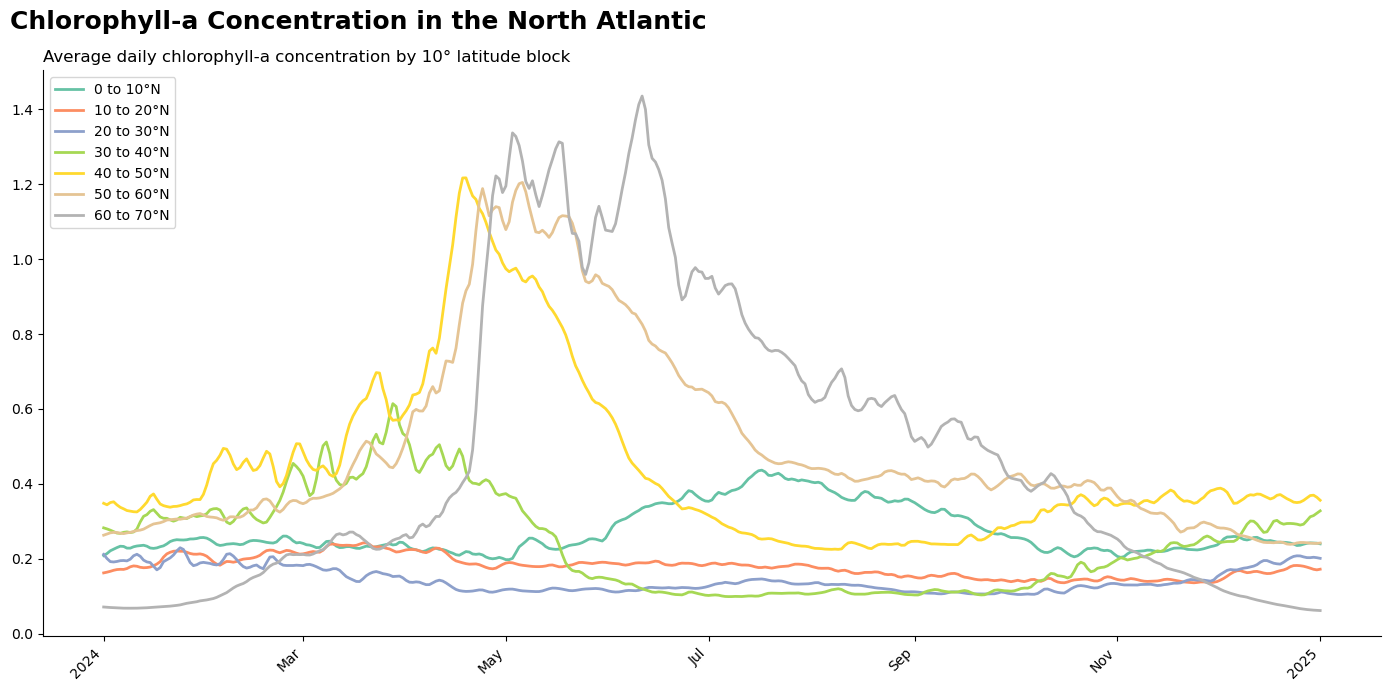

In [55]:
# Parse the 'date' column from "dd.mm.yy" format into datetime objects
chlorophyll_data["date"] = pd.to_datetime(chlorophyll_data["date"], format="%d.%m.%y", errors="coerce")

# Sort by date to ensure smooth plotting
chlorophyll_data = chlorophyll_data.sort_values("date").reset_index(drop=True)

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(14, 7))  # Define figure size

# Set up a colormap with as many colors as there are latitude bands
cmap = get_cmap("Set2", len(chlorophyll_data.columns) - 1)

# Plot each latitude band (skip the first column, which is 'date')
for i, col in enumerate(chlorophyll_data.columns[1:]):
    ax.plot(
        chlorophyll_data["date"],
        chlorophyll_data[col],
        label=col.replace("_", " ") + "°N",  # Format label nicely
        color=cmap(i),
        linewidth=2
    )

# --- Titles and labels ---
plt.suptitle(
    "Chlorophyll-a Concentration in the North Atlantic",
    fontsize=18, fontweight="bold", x=0.01, ha='left'
)
plt.title(
    "Average daily chlorophyll-a concentration by 10° latitude block",
    fontsize=12, loc='left'
)

# --- X-axis: auto-formatting for any time range ---
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for readability

# --- Styling ---
ax.legend(title="", loc="upper left", fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## 🧭 **7. Next Steps**

After exploring the chlorophyll-a patterns by latitude, you may notice that chlorophyll-a concentrations below 30°N remained relatively stable throughout the year. To understand this a bit more, I consulted with an ocean scientist, Elodie Gutknecht at Mercator Ocean. She explained that the North Atlantic Spring Bloom generally occurs between **30° and 70°N**, and is defined by a **sharp spike in phytoplankton concentrations** over a short period of time.

With this in mind, we can now focus our map visualization on the **2024 Spring Bloom Season** of (March to June) and a **smaller geographic window** that captures the most relevant activity.

In the next notebook, we'll extract daily chlorophyll-a timesteps from our NetCDF file and **export each one as a GeoTIFF**, allowing us to style and animate bloom dynamics in QGIS.

Continue to:  
👉 [`03_netcdf_to_rasters.ipynb`](03_netcdf_to_rasters.ipynb)
